# Examples

## Simple function minimization

Let's minimize the following simple function:

$$
f(x, y) = (x - 3.6)^2 + 2 (y+1.1)^2
$$

The global minimum is obvious: $f=0$ for $x=3.6, y=-1.1$. We now want to find this minimum using `iwopy`, in a setup as follows:

- Parameter bounds: $x, y \in [-5,5]$
- Unconstrained minimization
- Gradient based optimizer [IPOPT](https://esa.github.io/pagmo2/docs/cpp/algorithms/ipopt.html) from [pygmo](https://esa.github.io/pygmo2/)
- Analytical gradients

The usage of finite difference gradients will be demonstrated directly after. We start by importing the required classes from the `iwopy` package:

In [1]:
from iwopy import SimpleProblem, SimpleObjective
from iwopy.interfaces.pygmo import Optimizer_pygmo

The `SimpleProblem` will be instantiated with two float type variables `x` and `y` which will be passed on to all linked objectives and constraints. The `SimpleObjective` (and also the `SimpleConstraint` classes assume the same variables as the problem, in the same order. We can therefore implement the above function $f(x, y)$ and the derivative 
$$
g(v, x, y) = \left\{ 
\begin{array}{ll}
\mathrm df / \mathrm dx \ ,& \text{if} \ v = 0 \\
\mathrm df / \mathrm dy \ ,& \text{if} \ v = 1
\end{array}
\right.
$$ 
in a straight forward manner:

In [2]:
class MinFunc(SimpleObjective):
    def f(self, x, y):
        return (x - 3.6) ** 2 + 2 * (y + 1.1) ** 2

    def g(self, v, x, y, components):
        return 2 * (x - 3.6) if v == 0 else 4 * (y + 1.1)

Notice that the `components` argument of the function `g` is not used here since `f` is a single-component function.

In the case of multi-component functions the parameter `n_components` has to be passed to the `__init__` function of `SimpleObjective`, and `f` has to return a list of scalars. In that case also `g` has to return a list of results, with same length as the requested `components`. The same rules apply to classes derived from `SimpleConstraint`.

We can now proceed and setup the problem:

In [3]:
problem = SimpleProblem(
    name="minf",
    float_vars=["x", "y"],
    init_values_float=[0.0, 0.0],
    min_values_float=[-5.0, -5.0],
    max_values_float=[5.0, 5.0],
)
problem.add_objective(MinFunc(problem))
problem.initialize()

Problem 'minf' (SimpleProblem): Initializing
--------------------------------------------
  n_vars_int   : 0
  n_vars_float : 2
--------------------------------------------
  n_objectives : 1
  n_obj_cmptns : 1
--------------------------------------------
  n_constraints: 0
  n_con_cmptns : 0
--------------------------------------------


Note that in a similar way you can easily add constraints to the problem, by defining them in a class that is derived from `iwopy.Constraint` or `iwopy.SimpleConstraint` and then adding them via `problem.add_constraint(...)`. 

Adding additional objectives works in the same way, simply repeat `problem.add_objective(...)` as often as you want. However, be aware that not all optimizers can handle multiple objective cases.

Next, we create and initialize the solver:

In [4]:
solver = Optimizer_pygmo(
    problem,
    problem_pars=dict(),
    algo_pars=dict(type="ipopt", tol=1e-4),
)
solver.initialize()
solver.print_info()


Algorithm name: Ipopt: Interior Point Optimization [deterministic]
	C++ class name: pagmo::ipopt

	Thread safety: none

Extra info:
	Last optimisation return code: Solve_Succeeded (value = 0)
	Verbosity: 1
	Individual selection policy: best
	Individual replacement policy: best
	Numeric options: {tol : 0.0001}



Here `tol` is an `IPOPT` parameter that defines the convergence tolerance. Now we are finally ready - let's solve the problem!

In [5]:
results = solver.solve()
solver.finalize(results)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


 objevals:        objval:      violated:    viol. norm:
         1          15.38              0              0
         2        9.23375              0              0
         3        9.23375              0              0
         4        9.23375              0              0
         5        9.23375              0              0
         6        9.23375              0              0
         7        1.60594              0              0
         8      0.0440281              0              0
         9     0.00157443              0              0
        10    1.35988e-06              0           

In [6]:
print(results)

Results problem 'minf':
------------------------
  Float variables:
    0: x = 3.599999e+00
    1: y = -1.100000e+00
------------------------
  Objectives:
    0: f = 1.285221e-12
------------------------
  Success: True
------------------------



The `results` object is an instance of the class `OptResults`, cf. API. it carries attributes

- `vars_int`: The integer variables of the solution
- `vars_float`: The float variables of the solution
- `objs`: The objective function values of the solution
- `cons`: The constraint function values of the solution
- `problem_results`: The object returned by the problem when applying the solution
- `success` : Boolean flag indicating a successful solution
- `vnames_int`: The names of the integer variables
- `vnames_float`: The names of the float variables
- `onames`: The names of the objectives (all components)
- `cnames`: The names of the constraints (all components)

Next, we want to explore finite difference gradient calculations for the same example. We can either remove the function `g(v, x, y, components)` from the `MinFunc` class, or create it invoking the parameter `has_ana_derivs=False`. This will then ignore the analytical gradient definition in the class.

Additionally, we need to wrap the problem into a wrapper that provides numerical derivatives. There are two choices:

- `DiscretizeRegGrid`: A wrapper that evaluates the problem on a regular grid and calculates derivatives based on fixed grid point locations. Interpolation in between is optional (and increases the number of required function evaluations). The grid also offers a memory such that re-calculations of grid point results are minimized.
- `LocalFD`: A wrapper that evaluates local finite difference rules for derivative calculations. Hence the problem evaluation points are defined based on the current variables and hence not memorized since those usually differ with every call.

The `LocalFD` is usually the faster choice, unless you are expecting a lot of benefits from the memory capabilities of the regular grid. Here is an example how to use it for solving our problem:

In [7]:
from iwopy import LocalFD

In [8]:
problem = SimpleProblem(
    name="minf",
    float_vars=["x", "y"],
    init_values_float=[0.0, 0.0],
    min_values_float=[-5.0, -5.0],
    max_values_float=[5.0, 5.0],
)
problem.add_objective(MinFunc(problem, has_ana_derivs=False))

In [9]:
gproblem = LocalFD(problem, deltas=1e-4, fd_order=2)
gproblem.initialize()

Problem 'minf' (SimpleProblem): Initializing
--------------------------------------------
  n_vars_int   : 0
  n_vars_float : 2
--------------------------------------------
  n_objectives : 1
  n_obj_cmptns : 1
--------------------------------------------
  n_constraints: 0
  n_con_cmptns : 0
--------------------------------------------
Problem 'minf_fd' (LocalFD): Initializing
-----------------------------------------
  n_vars_int   : 0
  n_vars_float : 2
-----------------------------------------
  n_objectives : 1
  n_obj_cmptns : 1
-----------------------------------------
  n_constraints: 0
  n_con_cmptns : 0
-----------------------------------------


The `gproblem` object now corresponds to original `problem` with finite difference gradients of order 2. We can use the same gradient based solver as above for solving this problem:

In [10]:
solver = Optimizer_pygmo(
    gproblem,
    problem_pars=dict(),
    algo_pars=dict(type="ipopt", tol=1e-4),
)
solver.initialize()

results = solver.solve()
solver.finalize(results)


Optimisation return status: Solve_Succeeded (value = 0)

 objevals:        objval:      violated:    viol. norm:
         1          15.38              0              0
         2        9.23375              0              0
         3        9.23375              0              0
         4        9.23375              0              0
         5        9.23375              0              0
         6        9.23375              0              0
         7        1.60594              0              0
         8      0.0440281              0              0
         9     0.00157443              0              0
        10    1.35988e-06              0              0
        11    1.28522e-12              0              0

Problem name: minf_fd
	C++ class name: pybind11::object

	Global dimension:			2
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-5, -5]
	Upper bounds: [5

In [11]:
print(results)

Results problem 'minf_fd':
---------------------------
  Float variables:
    0: x = 3.599999e+00
    1: y = -1.100000e+00
---------------------------
  Objectives:
    0: f = 1.285221e-12
---------------------------
  Success: True
---------------------------



## Electrostatic potential minimization

The main purpose of `iwopy` is to be helpful when attacking more complicated optimization tasks than the minimization of simple analytical functions as above. As an example, we consider the minimization of an inverse distance type potential for a fully coupled system of $N$ particles in two dimensions. We can imagine such a system to be composed of $N$ individual point charges, each of them carrying the same electric unit charge. The potential that we want to minimize is then represented by
$$
V = \sum_{i\neq j} \frac 1 {|\mathrm r_i - \mathrm r_j|} \ , \quad \text{where} \quad \mathrm r_i = \left( \begin{array}{c} x_i \\ y_i \end{array} \right)
$$
denotes the two dimensional position vector of charge $i$ and the sum is over all unequal index pairs. This potential favours large distances between charges, hence we need to constrain them to a certain area for a meaningful solution. We confine them to a circle of radius $R$ by imposing $N$ constraints,
$$
|\mathrm r_i| \leq R \ , \quad \text{for all} \quad i = 0 \ldots N-1 \ .
$$
These are the required imports for this example:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from iwopy import Problem, Objective, Constraint
from iwopy.interfaces.pymoo import Optimizer_pymoo

We start by creating a specific class that describes the variables of our problem:

In [13]:
class ChargesProblem(Problem):
    def __init__(self, xy_init, radius):
        super().__init__(name="charges_problem")
        self.xy_init = xy_init
        self.n_charges = len(xy_init)
        self.radius = radius

    def var_names_float(self):
        """Defines the variable names"""
        vnames = []
        for i in range(self.n_charges):
            vnames += [f"x{i}", f"y{i}"]
        return vnames

    def initial_values_float(self):
        """Returns inital values, as given to constructor"""
        return self.xy_init.reshape(2 * self.n_charges)

    def min_values_float(self):
        """Minimal values for a square of size 2*radius"""
        return np.full(2 * self.n_charges, -self.radius)

    def max_values_float(self):
        """Maximal values for a square of size 2*radius"""
        return np.full(2 * self.n_charges, self.radius)

    def apply_individual(self, vars_int, vars_float):
        """Returns (x, y) variables for each charge"""
        return vars_float.reshape(self.n_charges, 2)

    def apply_population(self, vars_int, vars_float):
        """Returns (x, y) variables for each charge per individual"""
        n_pop = len(vars_float)
        return vars_float.reshape(n_pop, self.n_charges, 2)

    def get_fig(self, xy):
        """Get a figure showing the charges locations"""
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(xy[:, 0], xy[:, 1], color="orange")
        ax.add_patch(plt.Circle((0, 0), self.radius, color="darkred", fill=False))
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"N = {self.n_charges}")
        return fig

There are $2 N$ variables for this problem, and we order them as $(x_0, y_0, \ldots, x_{N-1}, y_{N-1})$. This is convenient, since the numpy reshaping operation `vars_float.reshape(n_charges, 2)` then represents an array of $(x_i, y_i)$ type arrays, which is handy for calculations.

Notice the two functions `apply_individual` and `apply_population`. They are being called during optimization whenever new variables are being set by the optimizer, and their purpose is to update the data in the problem class accordingly (excluding objectives and constraints, which we will deal with shortly).

The difference between the two functions is that `apply_individual` evaluates a single vector of new problem variables, whereas `apply_population` handles a full population of such vectors. The implementation of the latter function is not strictly required (alternatively a loop over individuals of the population will be evaluated), but it provides a chance for a vast speed-up by vectorized evaluation. This is particularly beneficial for genetic algorithms or other easily vectorizable approaches (in fact also the gradient calculation via `iwopy` discretizations makes use of this vectorization). Of course the chosen optimizer must be able to support vectorized evaluation for this to work. Both functions return any kind of evaluation data which will be forwarded to the objective and constraint evaluation.

So far we have only defined the problem variables. Objectives and constraints can be added to the problem via the `add_objective` and `add_constraint` functions, respectively. First, we implement the inverse distance potential as our objective:

In [14]:
class MinPotential(Objective):
    def __init__(self, problem):
        """Define the same variable names and ordering as in the problem"""
        super().__init__(problem, "potential", vnames_float=problem.var_names_float())
        self.n_charges = problem.n_charges

    def n_components(self):
        """The potential is a scalar function, hence one component"""
        return 1

    def maximize(self):
        """Indicates that the single component is to be minimized"""
        return [False]

    def calc_individual(self, vars_int, vars_float, problem_results, components=None):
        """This evaluates the potential. See problem.apply_individual
        for problem results"""
        xy = problem_results
        value = 0.0
        for i in range(1, self.n_charges):
            dist = np.maximum(np.linalg.norm(xy[i - 1, None] - xy[i:], axis=-1), 1e-10)
            value += 2 * np.sum(1 / dist)
        return value

    def calc_population(self, vars_int, vars_float, problem_results, components=None):
        """This evaluates the potential in vectorized manner.
        See problem.apply_population for problem results"""
        xy = problem_results
        n_pop = len(xy)
        value = np.zeros((n_pop, 1))
        for i in range(1, self.n_charges):
            dist = np.maximum(np.linalg.norm(xy[:, i - 1, None] - xy[:, i:], axis=-1), 1e-10)
            value[:, 0] += 2 * np.sum(1 / dist, axis=1)
        return value

Notice that the functions `calc_individual` and its (again optional) vectorized correspondent `calc_population` do not directly make use of the variables vector `vars_float`, which they could (and it would be perfectly fine, even intended), but instead of the `problem_results` provided by the problem functions `apply_individual` and `apply_population`.

Next, we implement the $N$ radial constraints:

In [15]:
class MaxRadius(Constraint):
    def __init__(self, problem, tol=1e-2):
        """Define the same variable names and ordering as in the problem"""
        super().__init__(
            problem, "radius", vnames_float=problem.var_names_float(), tol=tol
        )
        self.n_charges = problem.n_charges
        self.radius = problem.radius

    def n_components(self):
        """One constraint per charge"""
        return self.n_charges

    def vardeps_float(self):
        """Boolean array that defines which component depends
        on which variable (optional, default is on all)"""
        deps = np.zeros((self.n_components(), self.n_charges, 2), dtype=bool)
        np.fill_diagonal(deps[..., 0], True)
        np.fill_diagonal(deps[..., 1], True)
        return deps.reshape(self.n_components(), 2 * self.n_charges)

    def calc_individual(self, vars_int, vars_float, problem_results, components=None):
        """This evaluates the constraints, negative values are valid.
        See problem.apply_individual for problem results"""
        components = np.s_[:] if components is None else components
        xy = problem_results[components]
        r = np.linalg.norm(xy, axis=-1)
        return r - self.radius

    def calc_population(self, vars_int, vars_float, problem_results, components=None):
        """This evaluates the constraints in vectorized manner,
        negative values are valid. See problem.apply_population for
        problem results"""
        components = np.s_[:] if components is None else components
        xy = problem_results[:, components]
        r = np.linalg.norm(xy, axis=-1)
        return r - self.radius

Note that by default, negative constraint values represent validity. This can be changed by overloading the function `get_bounds` of the base class, see API, but is not recommended.

Also note that the function `vardeps_float` is only relevant for gradient based solvers that support gradient sparsity (e.g. `pygmo.ipopt`). It is irrelevant for the genetic algorithm that we want to use in this example, but added for the sake of completeness.

Now let's add the objective and the constraints and initialize the problem:

Problem 'charges_problem' (ChargesProblem): Initializing
--------------------------------------------------------
  n_vars_int   : 0
  n_vars_float : 40
--------------------------------------------------------
  n_objectives : 1
  n_obj_cmptns : 1
--------------------------------------------------------
  n_constraints: 1
  n_con_cmptns : 20
--------------------------------------------------------


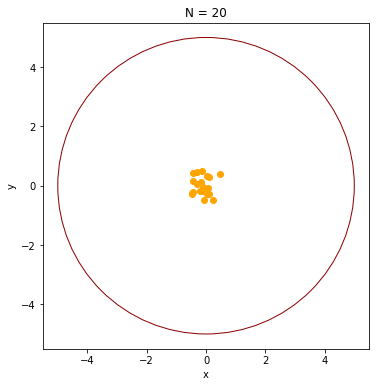

In [16]:
N = 20
R = 5

# generate random initial coordinates of the N charges:
xy = np.random.uniform(-R / 10.0, R / 10.0, (N, 2))

problem = ChargesProblem(xy, R)
problem.add_objective(MinPotential(problem))
problem.add_constraint(MaxRadius(problem))
problem.initialize()

fig = problem.get_fig(xy)
plt.show()

Finally, we can now setup the genetic solver [GA from pymoo](https://pymoo.org/algorithms/soo/ga.html) and solve the problem, here in vectorized form (flag `vectorize=True`):

In [17]:
solver = Optimizer_pymoo(
    problem,
    problem_pars=dict( 
        vectorize=True,
    ), 
    algo_pars=dict(
        type="ga",
        pop_size=100,
    ),
    setup_pars=dict(),
    term_pars=dict(
        type="default",
        n_max_gen=300,
        ftol=1e-6,
        xtol=1e-6,
    ),
)
solver.initialize()
solver.print_info()

results = solver.solve(verbosity=0)
solver.finalize(results)

Initializing Optimizer_pymoo
Selecting sampling: float_random (FloatRandomSampling)
Selecting algorithm: ga (GA)
Selecting termination: default (DefaultSingleObjectiveTermination)

Problem:
--------
  vectorize: True

Algorithm:
----------
  type: ga
  pop_size: 100

Termination:
------------
  n_max_gen: 300
  ftol: 1e-06
  xtol: 1e-06





Optimizer_pymoo: Optimization run finished
  Success: True
  Best potential = 78.18857190516454


Results problem 'charges_problem':
-----------------------------------
  Float variables:
    0: x0  = -3.925133e-01
    1: y0  = 4.984564e+00
    2: x1  = 2.009662e+00
    3: y1  = -1.038737e-01
    4: x2  = 4.998999e+00
    5: y2  = 9.778929e-02
    6: x3  = -4.118869e+00
    7: y3  = 2.830489e+00
    8: x4  = -4.833042e+00
    9: y4  = 1.280245e+00
    10: x5  = -2.121311e+00
    11: y5  = -4.526235e+00
    12: x6  = 4.712112e+00
    13: y6  = -1.668366e+00
    14: x7  = -4.581949e+00
    15: y7  = -1.999117e+00
    16: x8  = 2.969553e-01
    17: y8  = -4.990680e+00
    18: x9  = -2.411494e+00
    19: y9  = 4.378015e+00
    20: x10 = 2.229446e-01
    21: y10 = 2.613455e+00
    22: x11 = -1.853519e+00
    23: y11 = 3.172475e-01
    24: x12 = -1.617366e-01
    25: y12 = -2.637144e+00
    26: x13 = 3.843683e+00
    27: y13 = -3.191130e+00
    28: x14 = -4.984760e+00
    29: y14 = -3.824262e-01
    30: x15 = 2.512846e+00
    31: y15 = -4.320552e+00
    32: x16 = 3.377094e+00
    33: y16

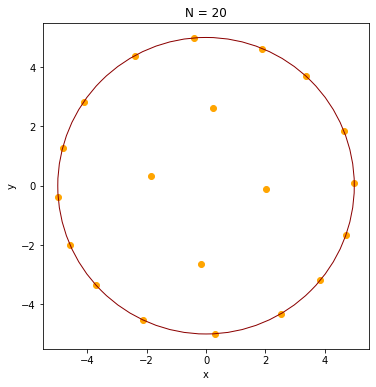

In [18]:
print(results)

xy = results.problem_results
fig = problem.get_fig(xy)
plt.show()

Note that this problem has many equivalent solutions, and the displayed result is the best solution that the genetic algorithm was able to find within its convergence criteria. With heuristic methods there is generally no guarantee or proof that a global optimum has been found. However, the objective function has clearly been minimized, and therefore the "design" was improved which is often the goal in engineering tasks.

For the fun of it, let's also solve the problem using iwopy's `GG` solver (stands for _Greedy Gradient_), now for 50 charges. This solver is a simple steepest decent algorithm which projects out directions that would violate constraints (and reverts those that already do). It supports iwopy's vectorization capabilities and hence can run fast for many variables. Of course it is not as advanced as other gradient based solvers, but for this particular problem it does a good job:

In [19]:
from iwopy.optimizers import GG

In [20]:
N = 50
R = 5

xy = np.random.uniform(-R / 10.0, R / 10.0, (N, 2))

problem = ChargesProblem(xy, R)
problem.add_objective(MinPotential(problem))
problem.add_constraint(MaxRadius(problem))

gproblem = LocalFD(problem, deltas=1e-2, fd_order=1)
gproblem.initialize()

solver = GG(
    gproblem,
    step_max=0.1,
    step_min=1e-4,
    vectorized=True,
)
solver.initialize()

results = solver.solve(verbosity=0)
solver.finalize(results)
print(results)

Problem 'charges_problem' (ChargesProblem): Initializing
--------------------------------------------------------
  n_vars_int   : 0
  n_vars_float : 100
--------------------------------------------------------
  n_objectives : 1
  n_obj_cmptns : 1
--------------------------------------------------------
  n_constraints: 1
  n_con_cmptns : 50
--------------------------------------------------------
Problem 'charges_problem_fd' (LocalFD): Initializing
----------------------------------------------------
  n_vars_int   : 0
  n_vars_float : 100
----------------------------------------------------
  n_objectives : 1
  n_obj_cmptns : 1
----------------------------------------------------
  n_constraints: 1
  n_con_cmptns : 50
----------------------------------------------------


GG: Optimization run finished
  Success: True
  Best potential = 587.9654163422571
Results problem 'charges_problem_fd':
--------------------------------------
  Float variables:
    0: x0  = -1.236208e+00
    1: y0  = -1.708999e+00
    2: x1  = 2.013002e+00
    3: y1  = -7.886082e-01
    4: x2  = 4.314693e+00
    5: y2  = 2.526550e+00
    6: x3  = -4.015066e+00
    7: y3  = 2.979854e+00
    8: x4  = 3.499176e+00
    9: y4  = 1.678460e+00
    10: x5  = -1.362974e+00
    11: y5  = 4.810645e+00
    12: x6  = -3.607953e+00
    13: y6  = 1.023309e+00
    14: x7  = -2.483641e+00
    15: y7  = -4.339552e+00
    16: x8  = 4.673964e+00
    17: y8  = -1.775998e+00
    18: x9  = 1.630472e+00
    19: y9  = -4.726692e+00
    20: x10 = -3.654452e+00
    21: y10 = -8.957545e-01
    22: x11 = 2.247764e+00
    23: y11 = 3.022091e+00
    24: x12 = -4.889755e+00
    25: y12 = -1.044440e+00
    26: x13 = -4.900226e-01
    27: y13 = -4.975941e+00
    28: x14 = 3.663091e+00
    29: y14 = 3.403210e+00
    3

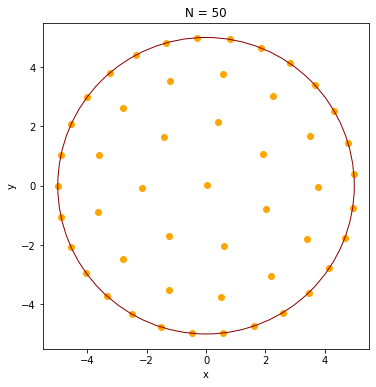

In [21]:
xy = results.problem_results
fig = problem.get_fig(xy)
plt.show()